In [3]:
import nltk
from nltk.tokenize import word_tokenize
import itertools
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import words
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
import sys, traceback


In [4]:
## AnalyticsVidhya
#https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy
import csv

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [5]:
import pandas as pd
import numpy as np
import os
import re
import spacy
from spacy import displacy
from textblob import Word
import gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
import pyLDAvis
import pyLDAvis.gensim
from sklearn.feature_extraction.text import TfidfVectorizer


In [6]:
#Kaggle, https://www.kaggle.com/akashram/topic-modeling-intro-implementation

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [7]:
# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()


Loading BokehJS ...

In [8]:
#Environment settings
warnings.filterwarnings('ignore')

%matplotlib inline
# %load_ext memory_profiler

In [7]:
#Installation needed
# !pip install nltk
# !pip install wordnet
# !pip install gensim
# !pip install google-compute-engine
# !pip install pyLDAvis
# !python3 -m spacy download en

In [8]:
#Download needed
# nltk.download('wordnet')


# Reading tsv files

In [9]:
#Limiting the number of files read due to system resource limitation
#Noticed that some of the files are throwing a format error . Examples: 154892.tsv, 193037.tsv

In [17]:
#Replaced single and double quotes with space
#! sh replace_pattern.sh 

In [7]:
DIR_SAVED='./saved'
FILENAME='df_raw_just_loaded.pkl'


In [5]:
#4.5 hours to load and pickle
LOAD_FILES=False

if LOAD_FILES:
    print("============== Started loading files ===================")
    df_raw=pd.DataFrame(columns=['filename','message','first_question','usernames'])
    NUM_FILES_READ=3000
    path='./dialogs_mod/4'
    for subdir, dirs, files in os.walk(path):
    #     for file in files[:NUM_FILES_READ]:
    #         print("file:",file)
        for file in files:
            if file.endswith((".tsv")):
                try:
                    print("Starting "+subdir+'/'+file)
                    df_file = pd.read_csv(subdir+'/'+file,header=None,names=['ts','from','to','message'],sep='\t')
                    df_file['message'] = df_file['message'].fillna(' ')
                    dict_file = {}
                    dict_file['filename']=file
                    dict_file['first_question']=df_file['message'][0]
                    dict_file['message']='. '.join(list(df_file['message']))
                    from_user=list(df_file['from'])
                    dict_file['usernames']=set(from_user)
        #           TODO: Include repliers 
                    df_raw=pd.concat([df_raw,pd.DataFrame.from_dict([dict_file])], sort=False, ignore_index=True)
                except:
                    print("An exception occurred at ",file)
                    print("-"*60)
                    traceback.print_exc(file=sys.stdout)
                    print("-"*60)
    print("============== Started saving to pickle files ===================")
    df_raw.to_pickle(DIR_SAVED+'/'+FILENAME)
else:
    print("============== Skipped loading files ===================")



============== Skipped loading files ===================


In [9]:
DIR_SAVED='./saved'
FILENAME='df_raw_just_loaded.pkl'


In [10]:
df_raw = pd.read_pickle(DIR_SAVED+'/'+FILENAME)
print(type(df_raw))
print(df_raw.shape)
print(df_raw.columns)


<class 'pandas.core.frame.DataFrame'>
(269023, 4)
Index(['filename', 'message', 'first_question', 'usernames'], dtype='object')


In [13]:
#Checking for NULL
df_raw['message'].isnull().sum()

0

In [10]:
df_raw['num_words_raw'] = df_raw['message'].apply(lambda x : len(x.split()))

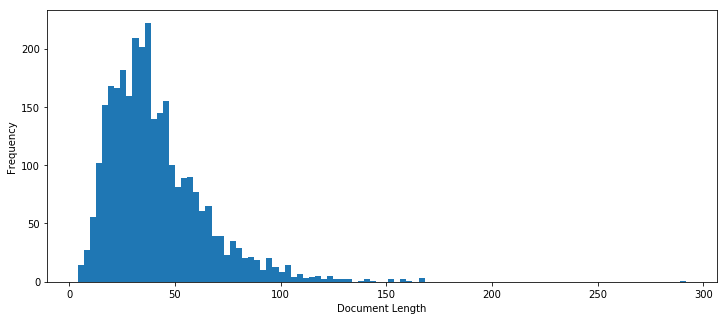

In [9]:
doc_lengths = df_raw['num_words_raw'].values
plt.figure(figsize=(12,5))
plt.hist(doc_lengths, bins=100)
# plt.xlim((0,40000))
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()


In [14]:
# examing the document length 
print("Average document length: {} words".format(round(np.mean(df_raw['num_words_raw']))))
print("Median document length: {} words".format(round(np.median(df_raw['num_words_raw']))))
print("Max document length: {} words".format(round(np.max(df_raw['num_words_raw']))))
print("Min document length: {} words".format(round(np.min(df_raw['num_words_raw']))))


Average document length: 42.0 words
Median document length: 37.0 words
Max document length: 344 words
Min document length: 4 words


In [15]:

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,200], bins=20, normed=False):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Document Length"
    fig.yaxis.axis_label = "Frequency"
    bp.output_file("hist.html")
    bp.show(fig)


In [16]:
    
plot_length_histogram(doc_lengths)

NameError: name 'doc_lengths' is not defined

# Usernames

In [17]:
#Listing all username for stop words
all_usernames=set()
for list1 in df_raw['usernames']:
    for list2 in list1:
        all_usernames.add(list2)


# Stop words

In [20]:
# stop = list(set(nltk.corpus.stopwords.words('english') + list(gensim.parsing.preprocessing.STOPWORDS)))
stop = nltk.corpus.stopwords.words('english')
print(len(stop))
additional_stop_words=['yes','no','ubuntu','linux','help','thanks','thank','work','support','error','problem','file',
                       'installed','install','installing','software']
additional_stop_words=['ubuntu','linux']
stop = stop + additional_stop_words
print(len(stop))
stop = stop + list(set(all_usernames))
print(len(stop))


179
181
140718


# Spacy

In [21]:
nlp_spacy = spacy.load("en_core_web_sm") 


# Preprocess

In [22]:
def f_preprocess_1(in_raw_msg):
    """
    Removes punctuation, stop words, digits, and domain names. Also lemmatizes and filters by certain pos tags 
    
    Input:
    ----------
    in_raw_msg : Unaltered complete message for a file

    Returns:
    -------
    Processed and tokenized messge
    """
    
    global all_usernames
    global lemmatizer 
    global stop
    result = in_raw_msg

    #lowercasing
    result = " ".join(x.lower() for x in result.split())
    
    #removing domain names
    pattern = r"[^\s]*\.(com|org|net)\S*"
    result = re.sub(pattern, '', result)
    pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    result = re.sub(pattern, '', result)
    pattern = r"www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    result = re.sub(pattern, '', result)

    #Removing punctuation
    result = re.sub('[^A-Za-z]+', ' ', result)
#     result = re.sub(r'[?]+', " ", result)  
#     result = re.sub(r'[ ]+\.', ".", result)  
#     result = re.sub(' --', '', result)
#     result = re.sub('[-_]+', '', result)
#     result = re.sub('[(]+', '', result)
#     result = re.sub('[)]+', '', result)
#     result = re.sub('[;]+', '', result)
#     result = re.sub('[\"]+', '', result)
#     #replacing dots(.)
#     result = re.sub('[\.]+', ' ', result)
#     #replacing screens/options with screens options
#     result = re.sub('[/]+', ' ', result)
#     #replacing i'm with im
#     result = re.sub('[\']+', '', result)
#     result = result.replace("!@#$%^&*()[]{};:,./<>?|`~-=_+", " ")  
#     result = re.sub(r'[!@#$%^&*()[]{};:,./<>?|`~-=_+]*', " ", result)  

    #Remove digits
    #result = re.sub(r"\d+", "", result)

    #Removing stop words
    result = ' '.join([word for word in result.split() if word not in stop])
    result = result.replace(r'\s+','')

    # Lemmatization: converts the word into its root word, rather than just stripping the suffices.
    # Going with spacy instead of nltk due to better output
    doc = nlp_spacy(result) 
    tmp_result=[]
    for token in doc: 
        tmp_result.append(token.lemma_) 
        #tmp_result.append(token.orth_) 
    result = ' '.join(tmp_result)
#     print("Lemma: ",result,"\n")
    

    #replacing multiple spaces with one
    result = re.sub('[ ]{2,}', ' ', result)
#     print("Multiple: ",result,"\n")

    #Considering words of length ge 2 and valid pos tags only
    
    result_valid=list()
    
    for (word,tag) in nltk.pos_tag(word_tokenize(result)):
        if len(word)>=2:
            result_valid.append(word)  

    result = ' '.join(result_valid)
#     print("Final: ",result,"\n")
    

    return result

In [23]:
# message_processed to hold the cleaned data
# 9 hours
df_raw['message_processed'] = df_raw['message'].apply(f_preprocess_1)


In [24]:
SAVE_TO_PICKLE=True
DIR_SAVED='./saved'
FILENAME_V2='df_raw_V2.pkl'

if SAVE_TO_PICKLE:
    df_raw.to_pickle(DIR_SAVED+'/'+FILENAME_V2)
else:
    print("======= Skipping SAVE_TO_PICKLE ===========")


In [11]:
LOAD_FROM_PICKLE=True


if LOAD_FROM_PICKLE:
    SAVE_TO_PICKLE=True
    DIR_SAVED='./saved'
    FILENAME_V2='df_raw_V2.pkl'
    
    df_raw = pd.read_pickle(DIR_SAVED+'/'+FILENAME_V2)
    print(type(df_raw))
    print(df_raw.shape)
    print(df_raw.columns)
else:
    print("======= Skipping LOAD_FROM_PICKLE ===========")



<class 'pandas.core.frame.DataFrame'>
(269023, 6)
Index(['filename', 'message', 'first_question', 'usernames', 'num_words_raw',
       'message_processed'],
      dtype='object')


In [12]:
df_raw[['message']].head(1).values[0][0]

'hello there. I am trying to install GLX on my Dapper (ATI 9200 mobile; IBM T42 laptop). I am following the guide that is on the Ubuntuforum.org, but it does not work as described. Who is willing to help me?. i think i didn t have to do anything except change driver from xorg.conf from ati to fglrx. The forum tells me:  Start gconf-editor and go to  apps/compiz/general/all screens/options  , but there is no section  apps/compiz  in gconf. I always use the fglrx driver, but there is some other strange problem'

In [13]:
df_raw['message_processed'].head(1)

0    install glx follow guide describe willing think anything except driver conf fglrx tell start gconf editor go compiz screen option section compiz gconf always fglrx driver problem
Name: message_processed, dtype: object

In [14]:
# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,200], bins=20, normed=False):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Document Length"
    fig.yaxis.axis_label = "Frequency"
    bp.output_file("hist.html")
    bp.show(fig)


# Analyzing length of processed messages

In [15]:
df_raw['num_words_processed'] = df_raw['message_processed'].apply(lambda string: len(string.split()))

In [16]:
# examing the document length 
print("Average message length: {} words".format(round(np.mean(df_raw['num_words_processed']))))
print("Median message length: {} words".format(round(np.median(df_raw['num_words_processed']))))
print("Max message length: {} words".format(round(np.max(df_raw['num_words_processed']))))
print("Min message length: {} words".format(round(np.min(df_raw['num_words_processed']))))


Average message length: 15.0 words
Median message length: 13.0 words
Max message length: 203 words
Min message length: 0 words


In [17]:
df_raw[df_raw['num_words_processed']==0]

,filename,message,first_question,usernames,num_words_raw,message_processed,num_words_processed
321,186965.tsv,So.... Anyone>. *?. anyone what?,So...,"{arch_is_awesome, ikonia}",5,,0
479,10077.tsv,hey guys. anyone home?. hi. hello?,hey guys,"{lenswipe, MATAH}",6,,0
1055,16411.tsv,quit. help. help. what s up?,quit,"{[snake], rio_}",6,,0
1492,77108.tsv,here s mine: http://i270.photobucket.com/albums/jj93/andrew_woodhead666/desktop.jpg?t=1231760517. - no no.. lol. ?. its fluxbox,here s mine: http://i270.photobucket.com/albums/jj93/andrew_woodhead666/desktop.jpg?t=1231760517,"{ActionParsnip, KeithGS}",11,,0
2336,82086.tsv,"怎么没人说话啊. 谢谢. 哦 原来如此. ??????????,?????????? ???",怎么没人说话啊,"{joerh99, Saiki}",6,,0
3338,101390.tsv,i am who i am because of who we all are. :o. namaste. *g*,i am who i am because of who we all are,"{mojo, sagredo}",14,,0
4235,181156.tsv,m z z: : w h a t s u t f 1 6 ?. l o m p f o n g : y o u r t e x t i s n t s p a c e d. m z z : i a m o n b r e e z y b a d g e r. y o u s h o u l d u s e t a b c o m p l e t e,m z z: : w h a t s u t f 1 6 ?,"{bruenig, jifli}",86,,0
5123,252932.tsv,"hi!. list!. 1, 2, 3, 4. 5",hi!,"{reisio, alessandro97}",7,,0
5695,92421.tsv,p. ?????. i from china. I m not ^^,p,"{sergiu_, fengxiaoxiao}",9,,0
6550,119561.tsv,hi. heyy. hey guys. support question?,hi,"{wafiiq_, bazhang}",6,,0


In [18]:
#Saving records to be discarded
df_processed_1 = df_raw[df_raw['num_words_processed']>10]
df_processed_1.shape

(170145, 7)

In [19]:
# examing the document length 
print("Average message length: {} words".format(round(np.mean(df_processed_1['num_words_processed']))))
print("Median message length: {} words".format(round(np.median(df_processed_1['num_words_processed']))))
print("Max message length: {} words".format(round(np.max(df_processed_1['num_words_processed']))))
print("Min message length: {} words".format(round(np.min(df_processed_1['num_words_processed']))))


Average message length: 19.0 words
Median message length: 17.0 words
Max message length: 203 words
Min message length: 11 words


In [20]:
df_raw['num_words_changed'] = df_raw['num_words_raw'] - df_raw['num_words_processed']

In [ ]:
df_raw[df_raw['num_words_changed']>0].sort_values(['num_words_changed'], ascending=[0])\
[['num_words_changed','filename','message','message_processed']].head(2)
                                                                           

# Document frequency

In [79]:
# from collections import defaultdict

# def f_document_word_frequency(in_record):
#     DF = defaultdict(int) 
#     print(in_record)
        

In [174]:
# from collections import defaultdict
# DF = defaultdict(int) 
# for list_words in df_processed_1['message_processed'].str.split():
#     for word in set(list_words):
#         DF[word] += 1

In [95]:
# df_raw.shape[0]

2706

In [ ]:
# for word in sorted(DF, key=DF.get, reverse=True):
#     print(word, DF[word])


In [295]:
# THRESHOLD_FREQ_WORDS_TO_ELIMINATE=500
# frequent_words = []
# for word, count in DF.items():
#     if count>=THRESHOLD_FREQ_WORDS_TO_ELIMINATE:
#         frequent_words.append(word)
# print(frequent_words)


['try', 'use', 'get']


In [ ]:
#Number of documents the word occurs in
# THRESHOLD_RARE_WORDS_TO_ELIMINATE=5
# rare_words = []
# for word, count in DF.items():
#     if count<=THRESHOLD_RARE_WORDS_TO_ELIMINATE:
#         rare_words.append(word)
# print(rare_words)


In [296]:
# def f_preprocess_2(in_message):
#     global frequent_words 
#     result = in_message
#     tmp_result =[]
#     for word in result.split():
#         if word not in frequent_words:
#             tmp_result.append(word)
    
#     result = tmp_result
#     return result


In [297]:
# df_processed_1['message_no_frequent_split'] = df_processed_1['message_processed'].apply(f_preprocess_2)
                                                                                  
                                                                                  

# Build BTM model

In [21]:
import biterm
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms
from biterm.cbtm import oBTM


In [22]:
df_processed_2 = df_processed_1.sample(n=100)

In [23]:
df_processed_2.shape[0]

100

In [24]:
df_processed_2.head()

,filename,message,first_question,usernames,num_words_raw,message_processed,num_words_processed
257270,157095.tsv,I ve went through google and forums and couldn t find it (even though it is simple). use a minimal window manager like fluxbox or blackbox and have the window manager run a startup script that wil...,I ve went through google and forums and couldn t find it (even though it is simple),"{MasterShrek, slavik}",70,go google forum though minimal run startup script start login gdm pick filesystem aware sure guess probably something,18
76296,219740.tsv,!ubottu help |Imsad. meh wrong caommand. `dpkg -L | grep achilles` might be fine. Just ignore that last bit.,!ubottu help |Imsad,"{Flannel, TecnaTranux}",19,ubottu imsad wrong caommand dpkg grep may fine ignore last bit,11
265838,76717.tsv,"Sorry about that, but I ve got an issue with the 8.10 Beta, as well as all of the 8.10 Alphas. So, would this be the room to talk about an issue with Ubuntu 8.10? Or could someone point me in the ...","Sorry about that, but I ve got an issue with the 8.10 Beta, as well as all of the 8.10 Alphas","{Bashew_, Vantrax}",75,sorry get issue alpha would room talk issue could point right direction sorry stuck irssi time show tooooo many channel least try,22
159648,51084.tsv,"I d like to be able to VNC into an Ubuntu machine running 9.04 Server, but it doesn t seem to be working. Do I need other things installed aside from vnc4server?. Do you have X installed? There n...","I d like to be able to VNC into an Ubuntu machine running 9.04 Server, but it doesn t seem to be working. Do I need other things installed aside from vnc4server?","{shawnps, grawity}",77,able machine running server seem work thing instal aside server instal need graphical interface seem connect display background sure package call would instal,23
260216,31423.tsv,i want to boot as verbose as possible (textmode). what is the best way to do that? work on boot up scripts? boot options?. in /etc/default/grub remove quiet splash from GRUB_CMDLINE_LINUX_DEFA...,i want to boot as verbose as possible (textmode). what is the best way to do that? work on boot up scripts? boot options?,"{Benkinooby, bastidrazor}",42,want possible textmode good script option etc remove splash cmdline splash run thank,13


In [25]:
df_processed_2.reset_index()
df_processed_2.index = range(0,df_processed_2.shape[0])


In [26]:
vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(df_processed_2.message_processed).toarray()


In [27]:
vocab = np.array(vec.get_feature_names())
biterms = vec_to_biterms(X)


In [28]:
btm = oBTM(num_topics=20, V=vocab)
topics = btm.fit_transform(biterms, iterations=100)


100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


In [31]:
vis = pyLDAvis.prepare(btm.phi_wz.T, topics, np.count_nonzero(X, axis=1), vocab, np.sum(X, axis=0))
pyLDAvis.save_html(vis, './online_btm.html')


In [32]:
df_processed_2.loc[50].message_processed, df_processed_2.loc[50].message

('restrict ftp account dir mean do not want other folder ftp server docs get subject google friend google ftp',
 'guys, how can i restrict on an ftp account that he just be in his home dir ?, i mean i dont want him to surf others folders ?. check the ftp server docs for chroot. from where can i get more info at this subject ?. google is your friend. google ftp+chroot')

topics[50].argmax()